In [6]:
# Import jax.numpy and any other library we might need.
import jax.numpy as jnp
import numpyro
import pandas as pd
import numpy as np

In [2]:
# Import the relevant modules of the library
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils

In [13]:
# seed値の設定
SEED = 1
N_CHAINS = 2
numpyro.set_host_device_count(N_CHAINS)

In [7]:
# rawデータ読み込み
df = pd.read_csv('data.csv')
print (df.head())

# 2020までを学習データにするためindex取得
print (df[df['Date']<='2020-12-31'].index.max())

         Date       TV    Radio  Banners    Sales
0  2018-01-07  13528.1     0.00     0.00  4779.80
1  2018-01-14      0.0  5349.65  2218.93  8405.72
2  2018-01-21      0.0  4235.86  2046.96  7353.87
3  2018-01-28      0.0  3562.21     0.00  4351.05
4  2018-02-04      0.0     0.00  2187.29  5472.92
155


In [8]:
# メディア投下量
media_data = jnp.array(df.loc[:,['TV','Radio','Banners']])
# メディア以外の特徴量
# extra_features = jnp.array(df.loc[:,['平均気温','降水量','週末FLG']])
# 売上
target = jnp.array(df.loc[:,'Sales'])
# Total Cost  各メディアの投下金額 (DEMOの方がsimulated_dummy関数が上手く動いていないよう)
costs = media_data.sum(axis=0) # media_dataがimpの(imp / 1000) * CPMなどと変換

In [9]:
# 訓練検証に分ける 
split_point = 155 + 1 # 2020までを訓練データとする 分割部分のindexを与える
# Media data
media_data_train = media_data[:split_point, ...]
media_data_test = media_data[split_point:, ...]
# Extra features # 今回はその他変数なし
# extra_features_train = extra_features[:split_point, ...]
# extra_features_test = extra_features[split_point:, ...]
# Target
target_train = target[:split_point]
target_test = target[split_point:]

In [10]:
# スケーリングする 平行移動ではなく、平均を1とする変換
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
# extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

media_data_train_scale = media_scaler.fit_transform(media_data_train)
# extra_features_train_scale = extra_features_scaler.fit_transform(extra_features_train)
target_train_scale = target_scaler.fit_transform(target_train)
costs_scale = cost_scaler.fit_transform(costs)

In [11]:
# modelのインスタンス化 メディアの減衰効果をcarryoverにする 
mmm = lightweight_mmm.LightweightMMM(model_name="carryover")

In [14]:
%%time
number_warmup=2000
number_samples=2000
# For replicability in terms of random number generation in sampling
# reuse the same seed for different trainings.
mmm.fit(
    media=media_data_train_scale,
    media_prior=costs_scale,
    target=target_train_scale,
    # extra_features=extra_features_train,
    number_warmup=number_warmup,
    number_samples=number_samples,
    number_chains=N_CHAINS,
    seasonality_frequency=52,# 日次データの場合365として以下の変数のコメントアウトをはずす
    # weekday_seasonality=True,
    seed=SEED)

C:\Users\mitsu\anaconda3\envs\mmm\Lib\site-packages\lightweight_mmm\lightweight_mmm.py:358: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|██████████████████████████| 4000/4000 [01:17<00:00, 51.54it/s, 255 steps of size 1.51e-02. acc. prob=0.97]


CPU times: total: 1min 20s
Wall time: 2min 22s


In [15]:
# 推定パラメータの統計量確認
mmm.print_summary()


                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
ad_effect_retention_rate[0]      0.64      0.13      0.66      0.43      0.84   2497.60      1.00
ad_effect_retention_rate[1]      0.31      0.29      0.21      0.00      0.80   1155.22      1.00
ad_effect_retention_rate[2]      0.27      0.24      0.19      0.00      0.64   2927.99      1.00
              coef_media[0]      0.20      0.03      0.20      0.15      0.25   2250.30      1.00
              coef_media[1]      0.04      0.02      0.04      0.00      0.07   1148.54      1.00
              coef_media[2]      0.11      0.04      0.11      0.04      0.17   1378.99      1.00
              coef_trend[0]      0.01      0.00      0.01      0.00      0.01   1157.90      1.00
                 expo_trend      1.06      0.10      1.05      0.90      1.23   1275.55      1.00
                exponent[0]      0.85      0.11      0.87      0.69      1.00   2590.48      1.00
                exp

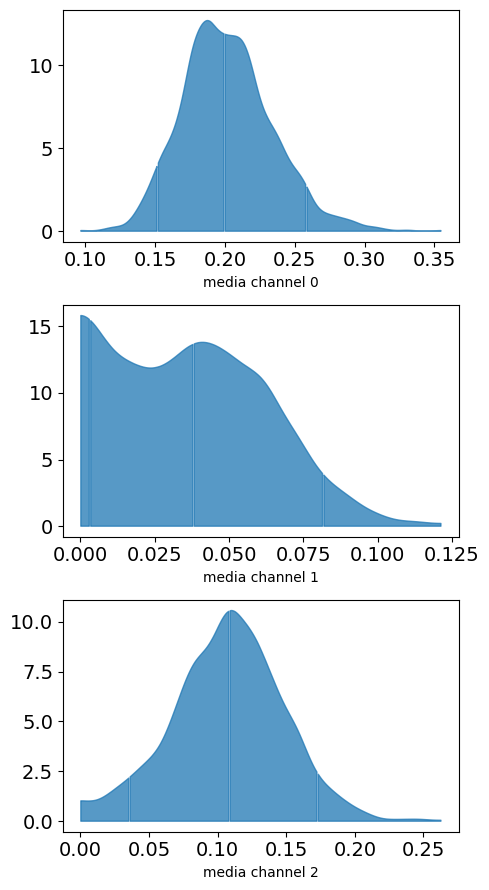

In [16]:
plot.plot_media_channel_posteriors(media_mix_model=mmm)

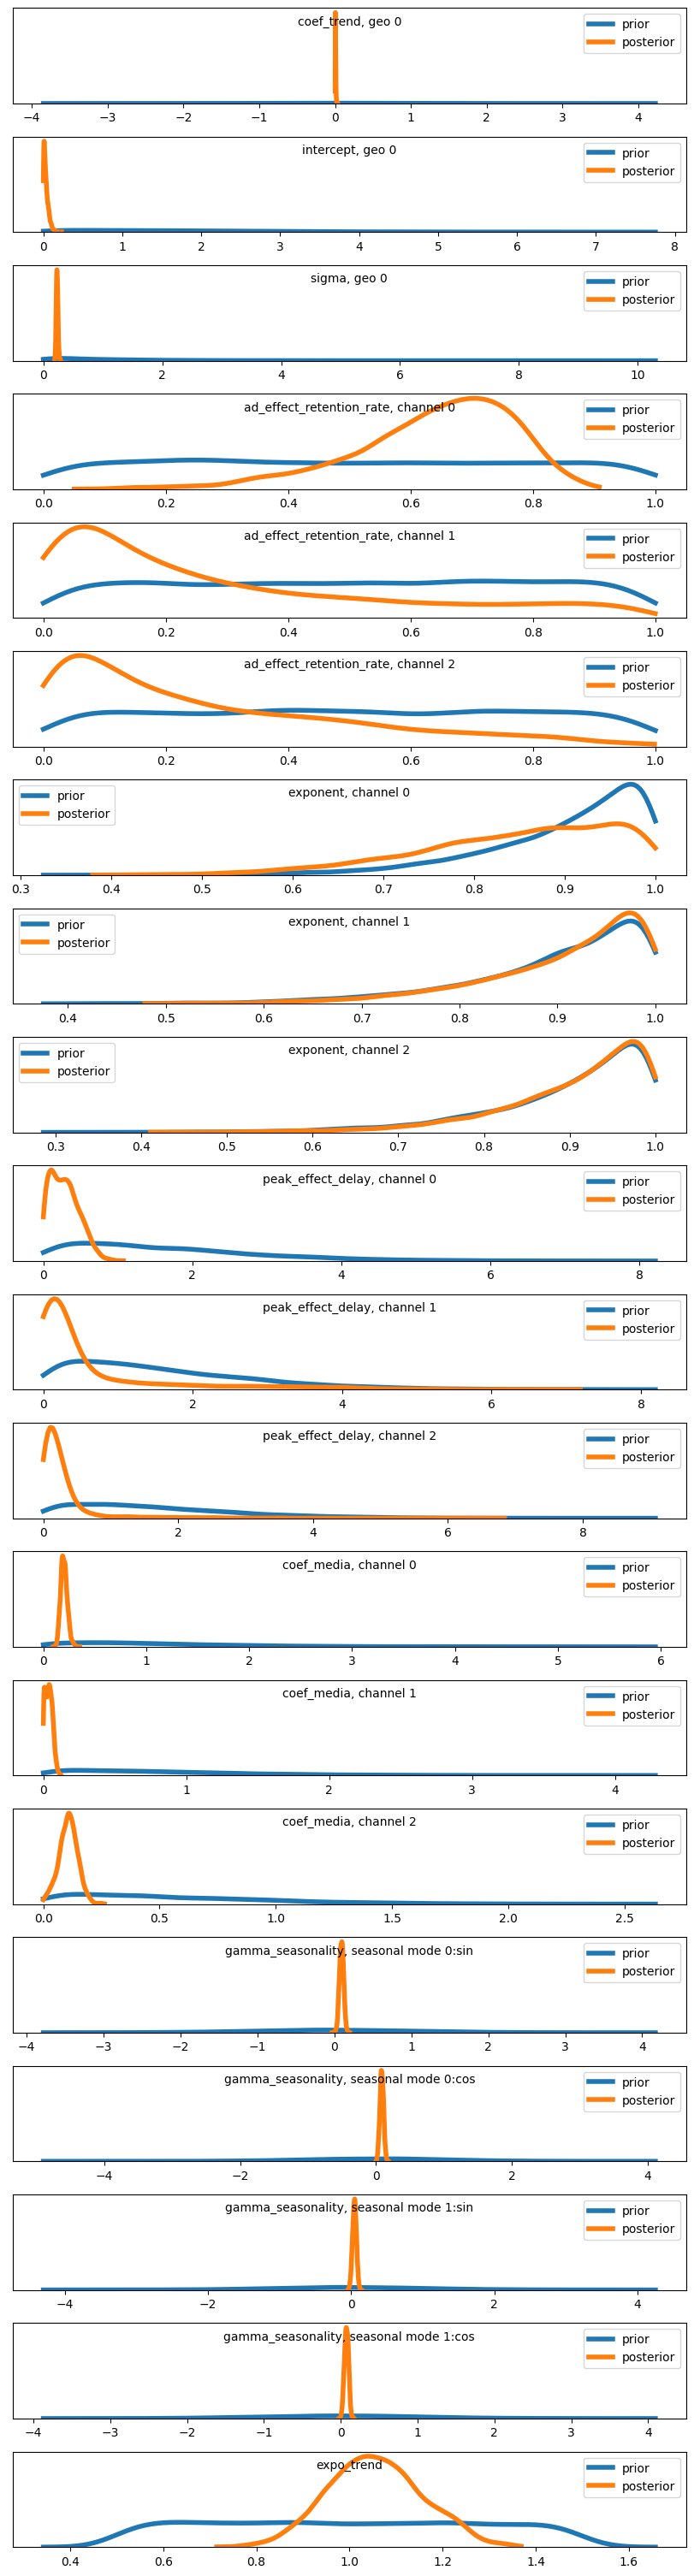

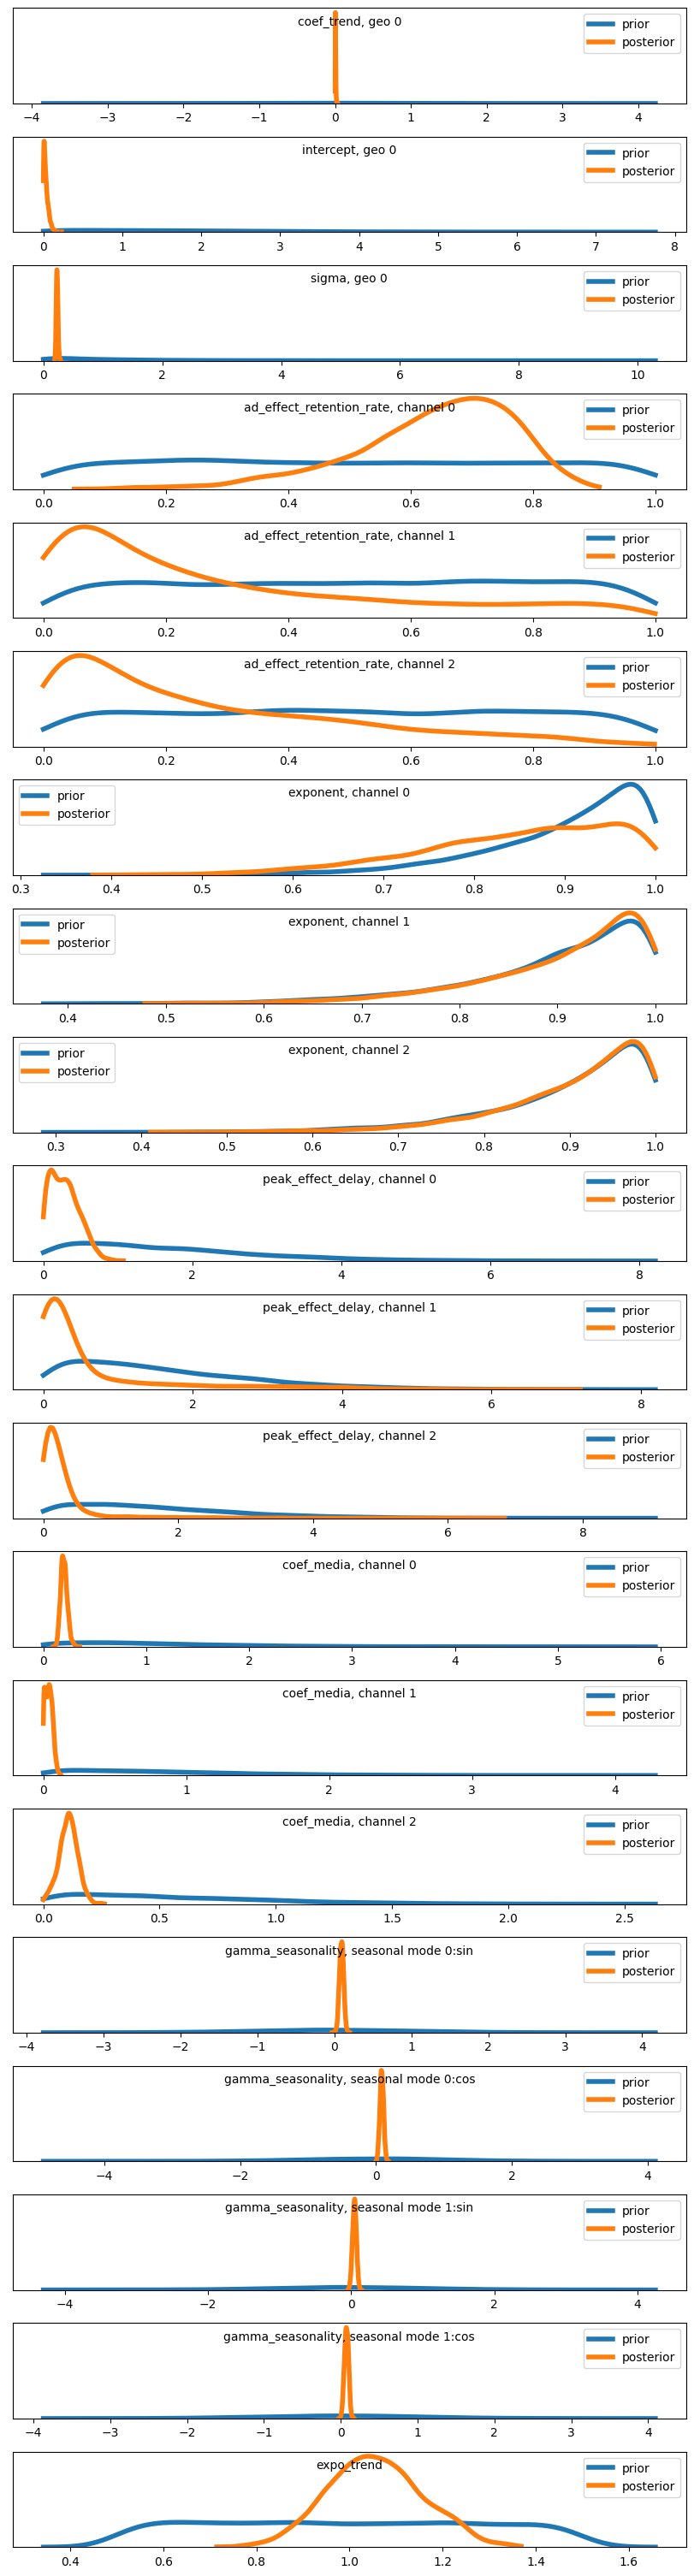

In [17]:
plot.plot_prior_and_posterior(media_mix_model=mmm)

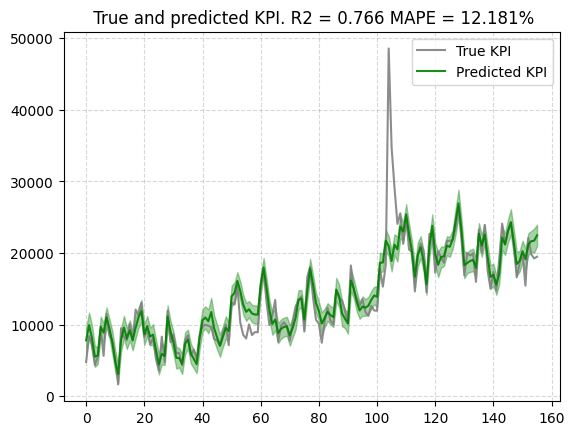

In [18]:
# scaleある場合
plot.plot_model_fit(mmm, target_scaler=target_scaler)

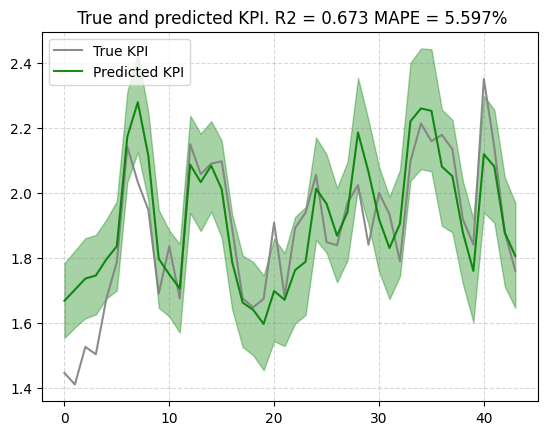

In [19]:
# testデータに当てはめる
new_predictions = mmm.predict(media=media_scaler.transform(media_data_test),
                              # extra_features=extra_features_scaler.transform(extra_features_test),
                              seed=SEED)
# new_predictions.shape
# plotする
plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,
                                 out_of_sample_target=target_scaler.transform(target_test) )

In [20]:
# 推定値などを出力
media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)

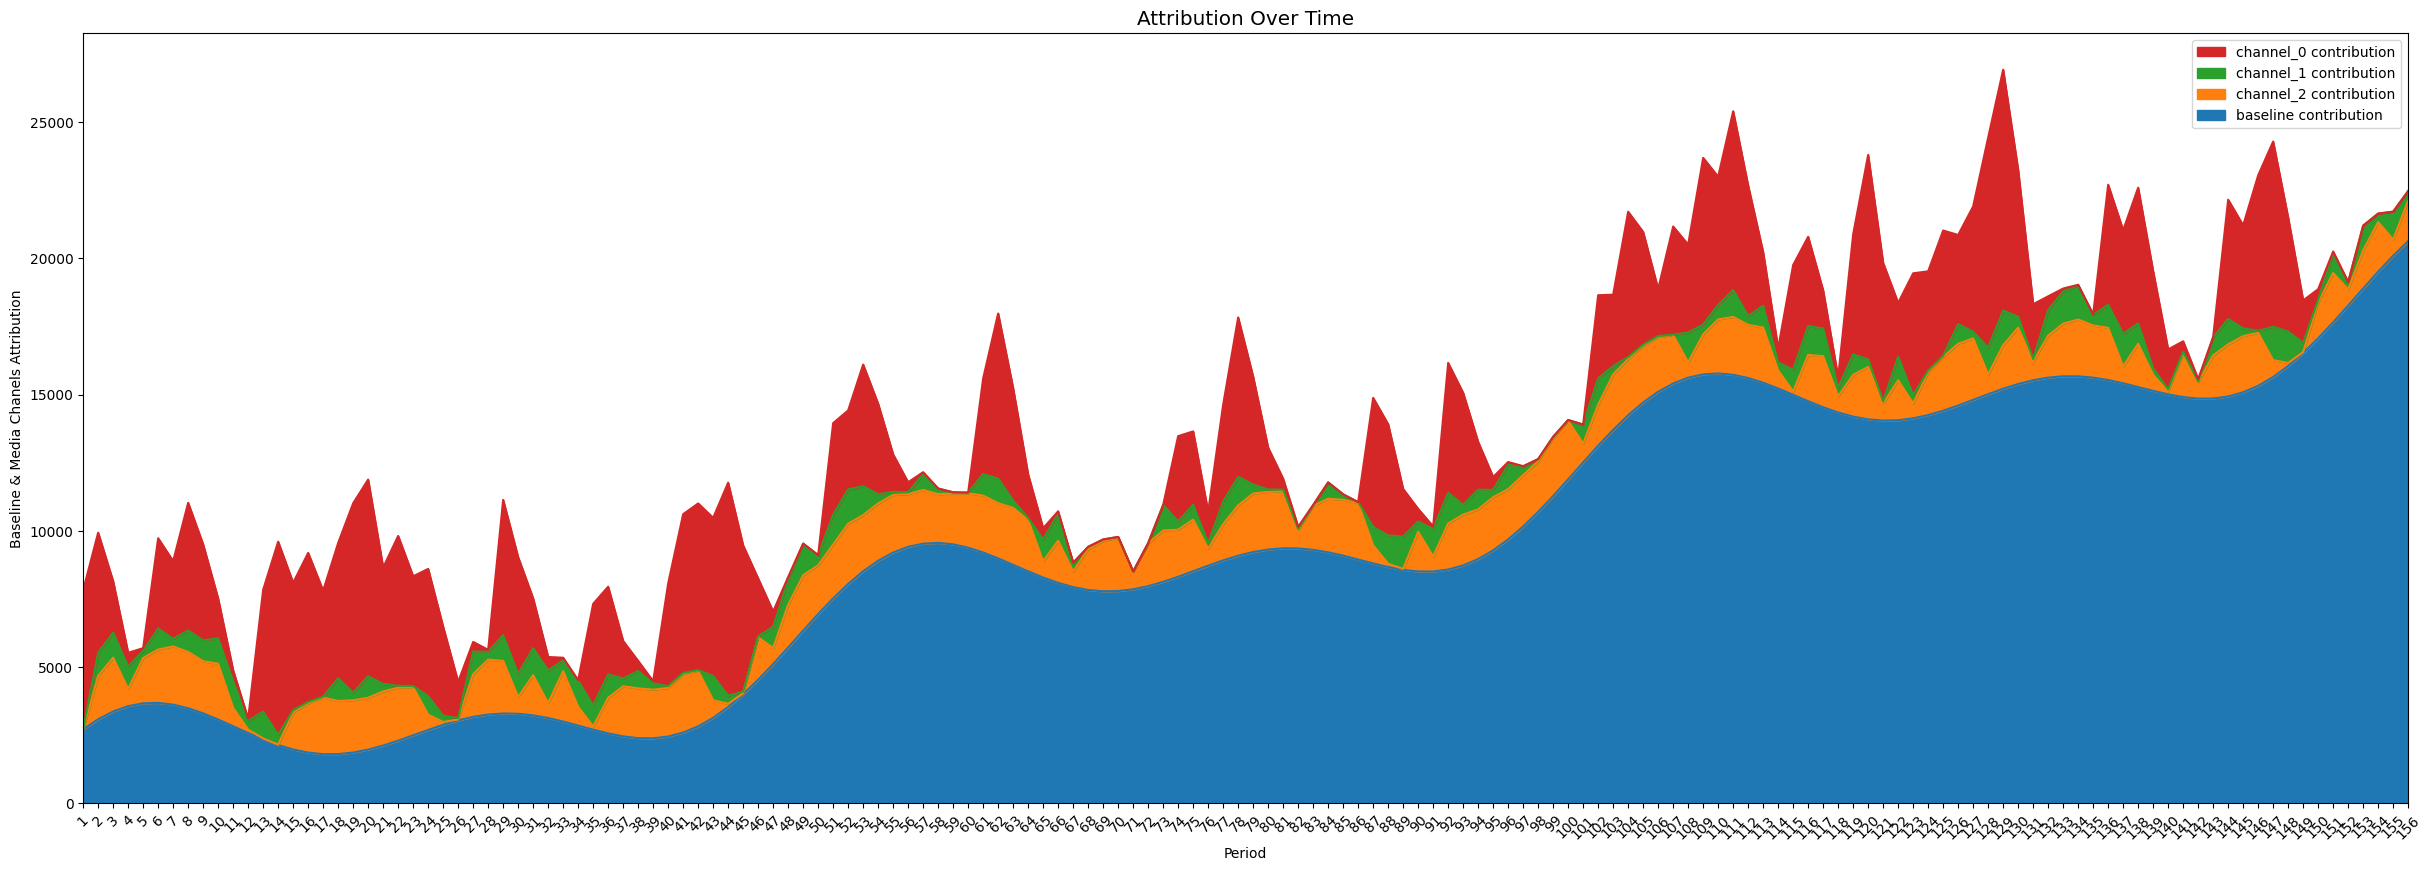

In [21]:
# 貢献度の可視化
plot.plot_media_baseline_contribution_area_plot(media_mix_model=mmm,
                                                target_scaler=target_scaler,
                                                fig_size=(30,10))

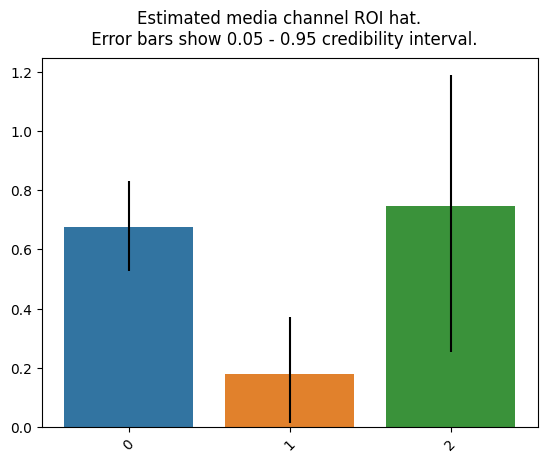

In [22]:
# ROI可視化
plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat")

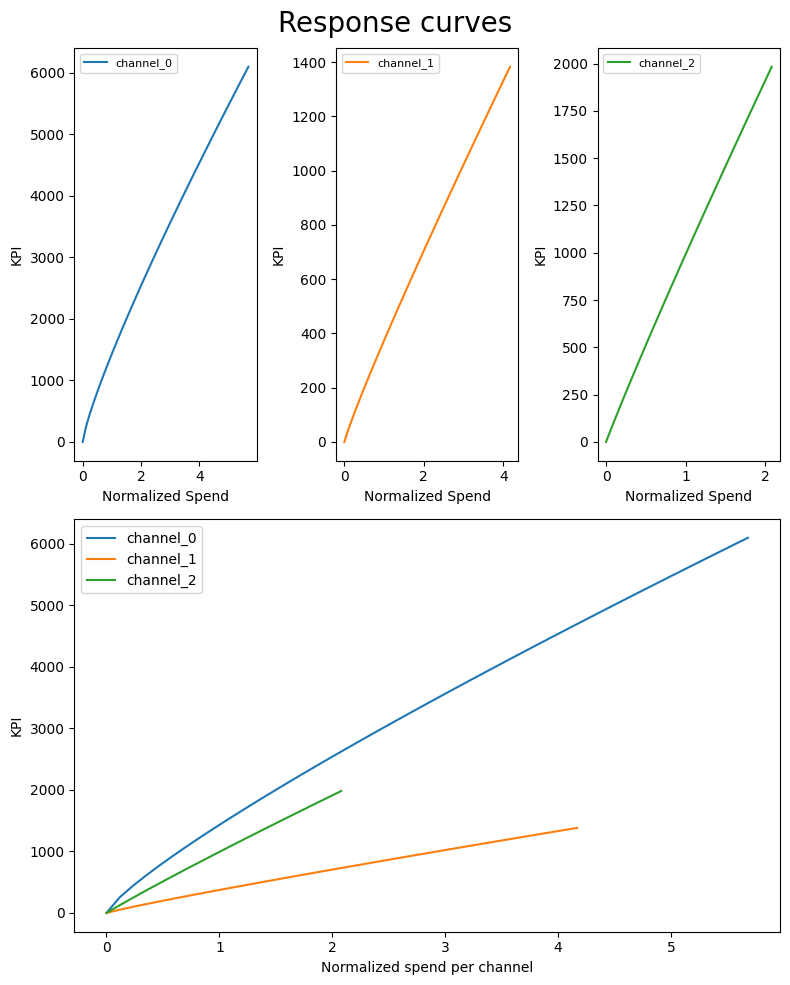

In [23]:
# メディア投下量と売上の関係
plot.plot_response_curves(
    media_mix_model=mmm, target_scaler=target_scaler, seed=SEED)

In [24]:
# 成果変数の円/成果の単位を入力→売上円であるため、全部1でOK
prices = jnp.ones(mmm.n_media_channels)

In [25]:
# 最適化したい期間
n_time_periods = media_data_test.shape[0]
print (n_time_periods)
# 予算の総量
budget = jnp.sum(media_data_train.mean(axis=0)) * n_time_periods
print (budget)

44
290177.47


In [26]:
# Run optimization with the parameters of choice.
solution, kpi_without_optim, previous_media_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    # extra_features=extra_features_scaler.transform(extra_features_test)[:n_time_periods],
    budget=budget,
    prices=prices,
      bounds_lower_pct = .5,
    bounds_upper_pct = .5,
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    seed=SEED)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1188045.3457745614
            Iterations: 17
            Function evaluations: 112
            Gradient evaluations: 16


In [27]:
# Obtain the optimal weekly allocation.
optimal_buget_allocation = prices * solution.x
optimal_buget_allocation

Array([146204.75 ,  48742.773,  95229.95 ], dtype=float32)

In [28]:
# similar renormalization to get previous budget allocation
previous_budget_allocation = prices * previous_media_allocation
previous_budget_allocation

Array([129205.29 ,  97485.55 ,  63486.633], dtype=float32)

In [29]:
# Both these values should be very close in order to compare KPI
budget, optimal_buget_allocation.sum()

(Array(290177.47, dtype=float32), Array(290177.47, dtype=float32))

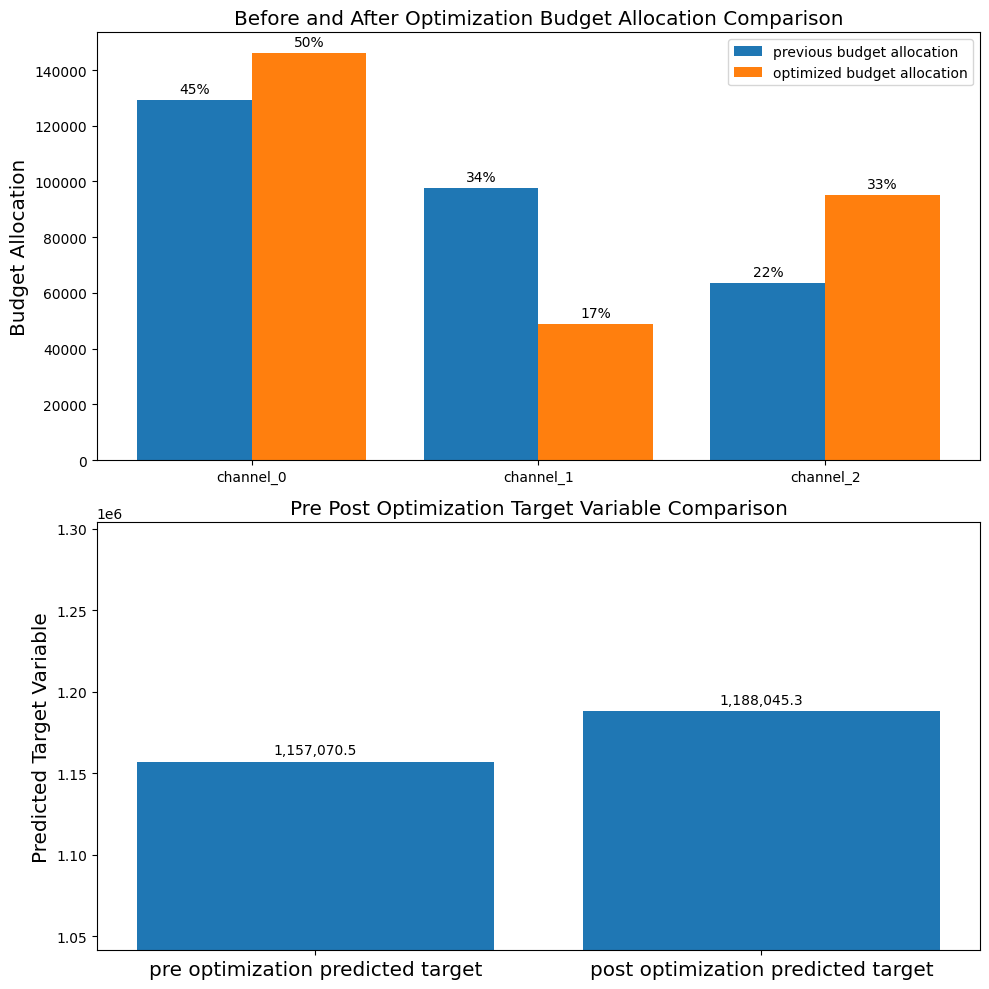

In [30]:
# 最適化前後の予算配分比率をプロット
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm, 
                                                kpi_with_optim=solution['fun'], 
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation, 
                                                previous_budget_allocation=previous_budget_allocation, 
                                                figure_size=(10,10))